# INDEX
[1. PASCAL VOC TRAINED MODEL](#PASCAL-VOC-TRAINED-MODEL "Goto PASCAL-VOC-TRAINED-MODEL")<br>
[2. MS COCO TRAINED MODEL](#MS-COCO-TRAINED-MODEL "Goto MS-COCO-TRAINED-MODEL")

In [1]:
from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image
from keras.optimizers import Adam
import cv2
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd300 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

%matplotlib inline

from imageio import imread
from PIL import Image
from imutils.video import FPS
import time
import os

Using TensorFlow backend.


# PASCAL VOC TRAINED MODEL
[INDEX](#INDEX "Goto INDEX")

In [2]:
# Set the image size.
img_height = 300
img_width = 300

## 1. Load trained SSD
You can find the download links to all the trained model weights in the README.

### 1.1. Build the model and load trained weights into it

In [3]:
# 1: Build the Keras model

K.clear_session() # Clear previous models from memory.

model = ssd_300(image_size=(img_height, img_width, 3),
                n_classes=20,
                mode='inference',
                l2_regularization=0.0005,
                scales=[0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05], # The scales for MS COCO are [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05]
                aspect_ratios_per_layer=[[1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5]],
                two_boxes_for_ar1=True,
                steps=[8, 16, 32, 64, 100, 300],
                offsets=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
                clip_boxes=False,
                variances=[0.1, 0.1, 0.2, 0.2],
                normalize_coords=True,
                subtract_mean=[123, 117, 104],
                swap_channels=[2, 1, 0],
                confidence_thresh=0.5,
                iou_threshold=0.45,
                top_k=200,
                nms_max_output_size=400)

# 2: Load the trained weights into the model.
weights_path = 'pretrained_weights/VGG_VOC0712_SSD_300x300_iter_120000.h5'

model.load_weights(weights_path, by_name=True)

# 3: Compile the model so that Keras won't complain the next time you load it.
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

W0709 11:27:55.131799  5664 module_wrapper.py:139] From C:\Users\abhinav.jhanwar\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0709 11:27:55.133809  5664 module_wrapper.py:139] From C:\Users\abhinav.jhanwar\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0709 11:27:55.453238  5664 module_wrapper.py:139] From C:\Users\abhinav.jhanwar\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0709 11:27:55.454244  5664 module_wrapper.py:139] From C:\Users\abhinav.jhanwar\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:51

Or

### 1.2. Load a trained model

In [ ]:
# TODO: Set the path to the `.h5` file of the model to be loaded.
model_path = 'model.h5'

# We need to create an SSDLoss object in order to pass that to the model loader.
ssd_loss = SSDLoss(neg_pos_ratio=3, n_neg_min=0, alpha=1.0)

K.clear_session() # Clear previous models from memory.

model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                               'L2Normalization': L2Normalization,
                                               'DecodeDetections': DecodeDetections,
                                               'compute_loss': ssd_loss.compute_loss})

## USING LOCAL IMAGES

## 2. Load some images

Load some images for which you'd like the model to make predictions.

In [7]:
orig_images = [] # Store the images here.
input_images = [] # Store resized versions of the images here.

images_folder = 'C:/Users/abhinav.jhanwar/objects/'
images = os.listdir(images_folder)

for img_path in images:
    img_path = os.path.join(images_folder, img_path)
    orig_images.append(imread(img_path))
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img = image.img_to_array(img) 
    input_images.append(img)
input_images = np.array(input_images)


## 3. Make predictions

In [9]:
y_pred = model.predict(input_images)

In [12]:
confidence_threshold = 0.5

y_pred_thresh = [y_pred[k][y_pred[k,:,1] > confidence_threshold] for k in range(y_pred.shape[0])]

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_thresh[0])

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  7.     0.92 256.24 235.34 300.35 277.1 ]
 [  7.     0.65   5.8  240.61  32.43 266.21]
 [  7.     0.51 139.85 249.98 171.68 266.73]
 [  6.     0.5   89.88 230.68 152.96 262.11]]


## 4. Visualize the predictions

We just resized the input image above and made predictions on the distorted image. We'd like to visualize the predictions on the image in its original size though, so below we'll transform the coordinates of the predicted boxes accordingly.

In [13]:
def draw_predict(frame, left, top, right, bottom, label, conf=-1):
    # Draw a bounding box.
    cv2.rectangle(frame, (left, top), (right, bottom), COLOR_YELLOW, 2)

    text = '{}: {:.2f}'.format(label, conf)

    # Display the label at the top of the bounding box
    label_size, base_line = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)

    top = max(top, label_size[1])
    cv2.putText(frame, text, (left, top - 4), cv2.FONT_HERSHEY_SIMPLEX, 0.4,
                COLOR_WHITE, 1)
    

# Default colors
COLOR_BLUE = (255, 0, 0)
COLOR_GREEN = (0, 255, 0)
COLOR_RED = (0, 0, 255)
COLOR_WHITE = (255, 255, 255)
COLOR_YELLOW = (0, 255, 255)

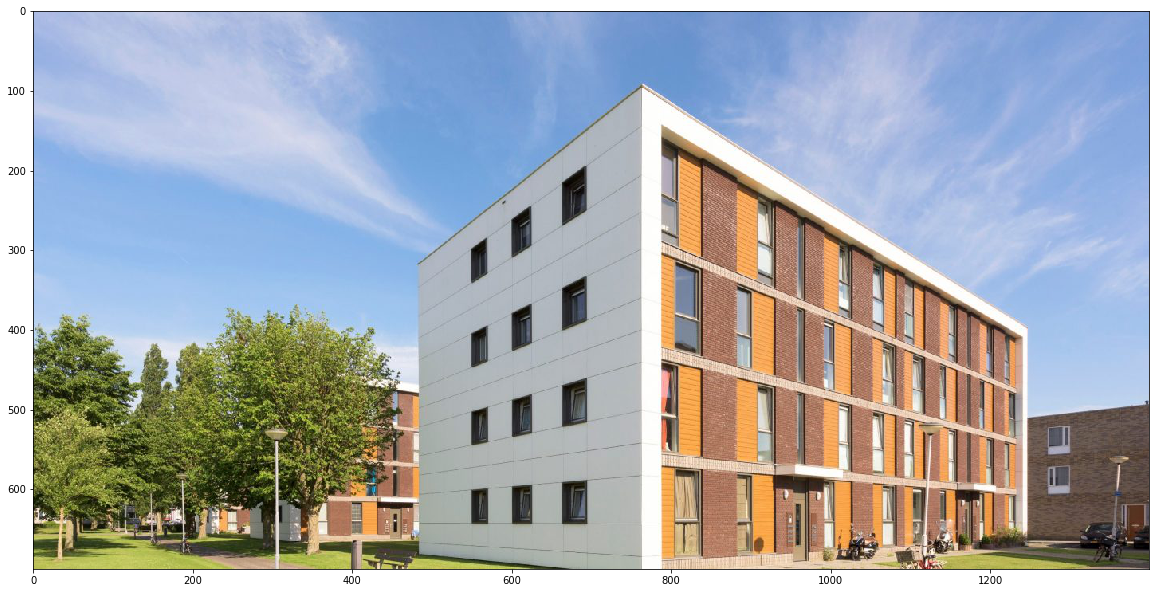

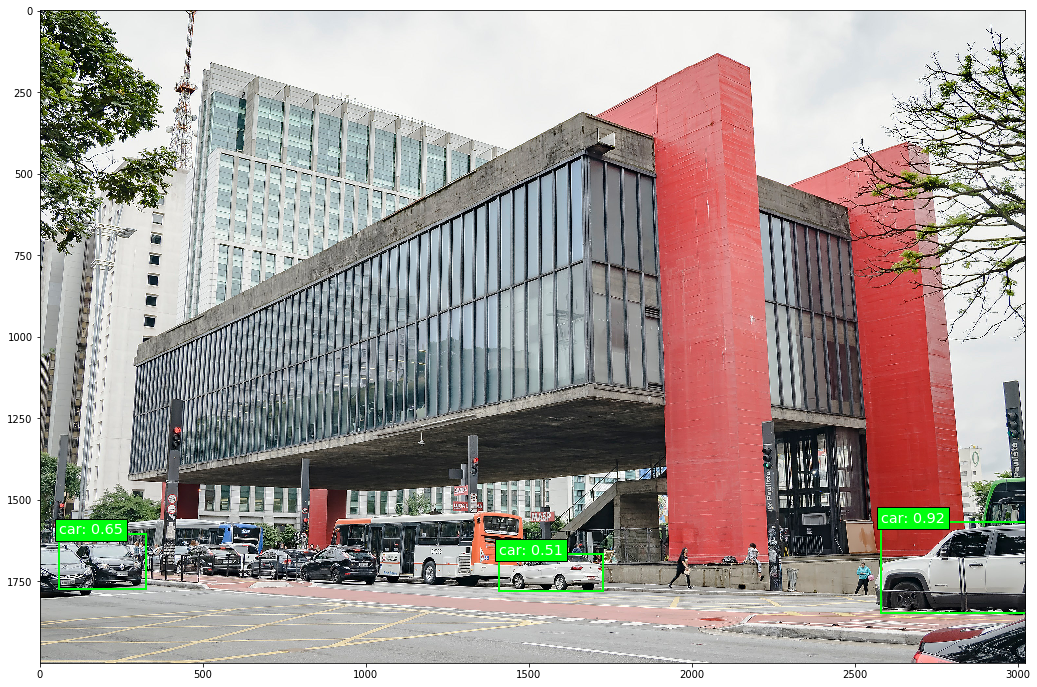

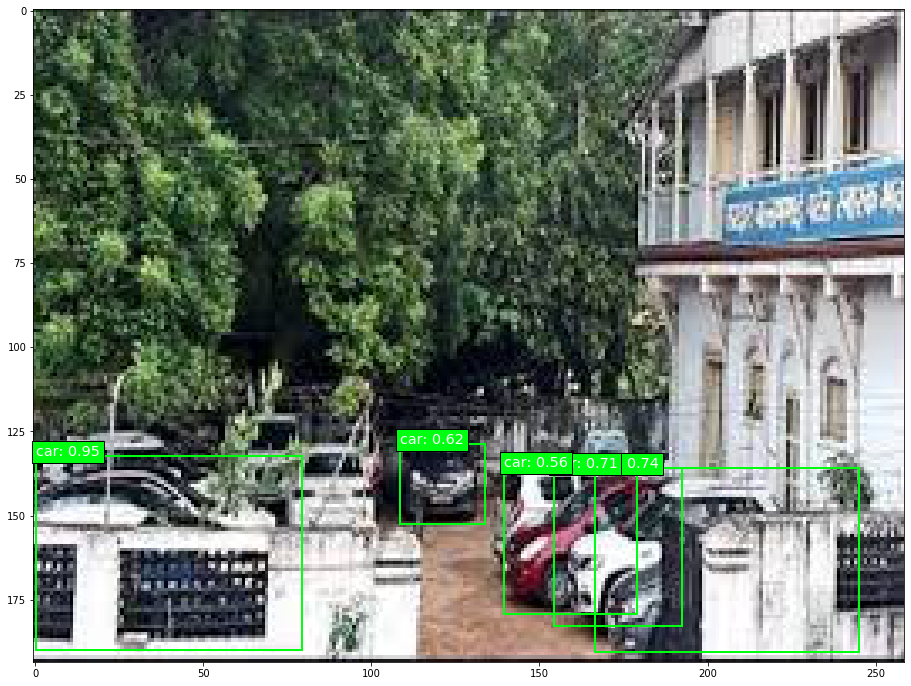

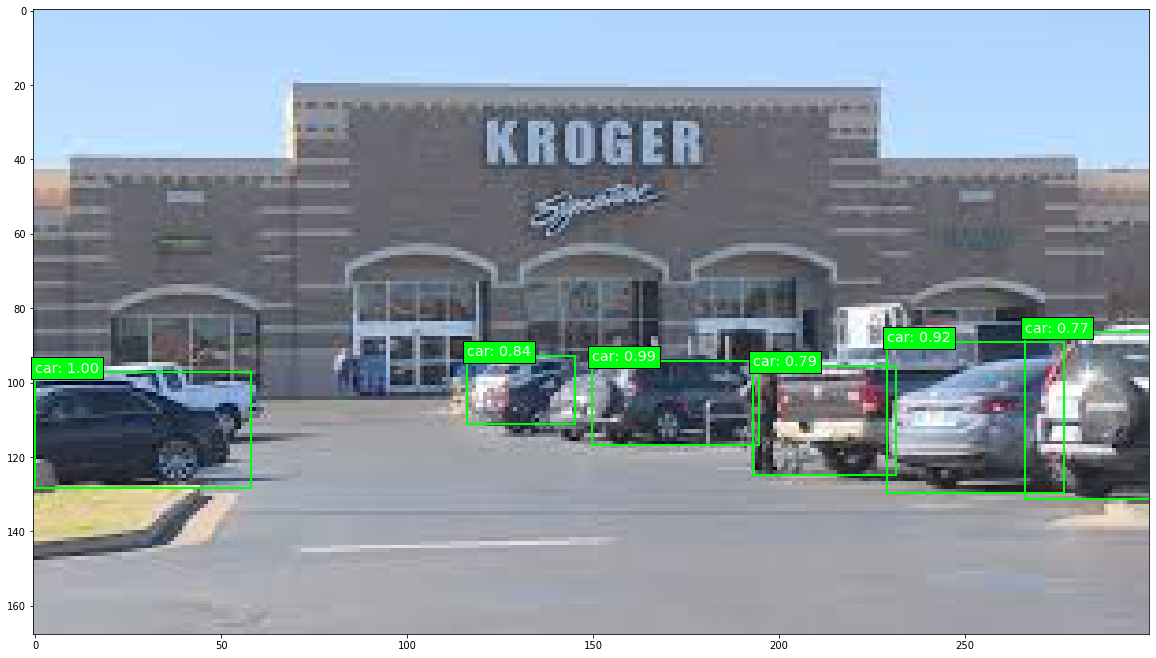

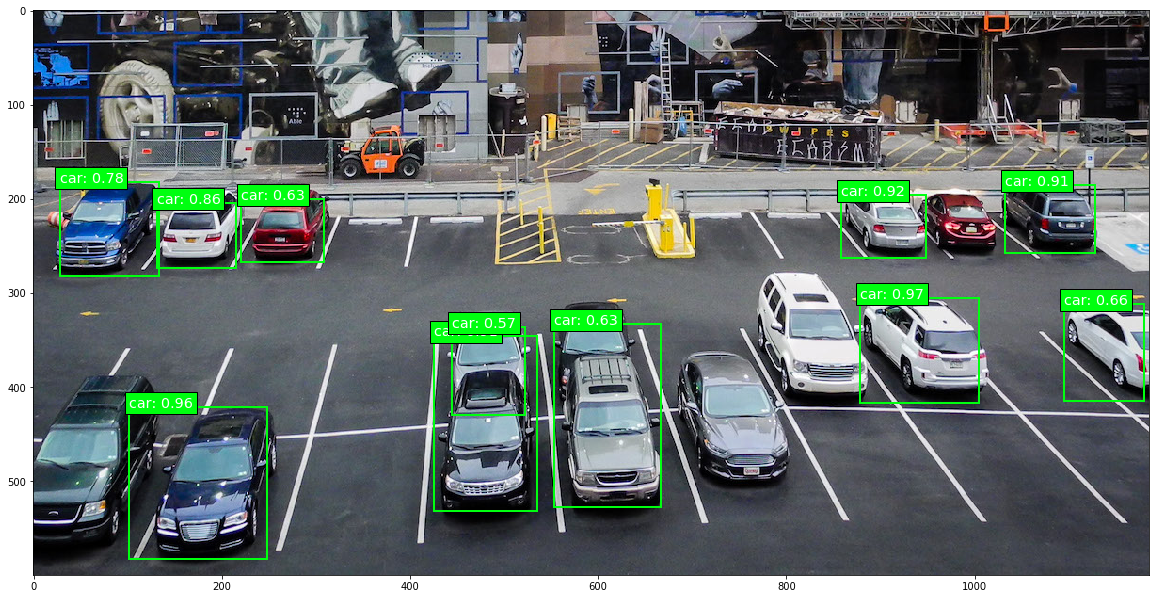

In [15]:
# Display the image and draw the predicted boxes onto it.

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
classes = ['background',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat',
           'chair', 'cow', 'diningtable', 'dog',
           'horse', 'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor']

for i, pred in enumerate(y_pred_thresh):
    plt.figure(figsize=(20,12))
    plt.imshow(orig_images[i])
    current_axis = plt.gca()
    for box in pred:
        # Transform the predicted bounding boxes for the 300x300 image to the original image dimensions.
        xmin = box[2] * orig_images[i].shape[1] / img_width
        ymin = box[3] * orig_images[i].shape[0] / img_height
        xmax = box[4] * orig_images[i].shape[1] / img_width
        ymax = box[5] * orig_images[i].shape[0] / img_height
        color = colors[int(box[0])]
        label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
        current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
        current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})
    plt.show()

## webcam

In [5]:
classes = ['background',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat',
           'chair', 'cow', 'diningtable', 'dog',
           'horse', 'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor']


cap = cv2.VideoCapture('test/horses.mp4')
flag = True
time.sleep(2.0)

fps = FPS().start()

while True:
    ret, frame = cap.read()
    if ret!=True:
        print('Not able to load image from webcam')
        break
        
    if flag:
        # initialize our video writer
        fourcc = cv2.VideoWriter_fourcc(*"MJPG")
        writer = cv2.VideoWriter('prediction.avi', fourcc, 30, (frame.shape[1], frame.shape[0]), True)
        flag = False
        
    cv2.imwrite('frame.jpg', frame)
    img = image.load_img('frame.jpg', target_size=(img_height, img_width))
    img = image.img_to_array(img) 
    
    y_pred = model.predict(np.array([img]))
    
    confidence_threshold = 0.5
    y_pred_thresh = [y_pred[k][y_pred[k,:,1] > confidence_threshold] for k in range(y_pred.shape[0])]

    #np.set_printoptions(precision=2, suppress=True, linewidth=90)
    #print("Predicted boxes:\n")
    #print('   class   conf xmin   ymin   xmax   ymax')
    #print(y_pred_thresh[0])
    
    for box in y_pred_thresh[0]:
        # Transform the predicted bounding boxes for the 300x300 image to the original image dimensions.
        xmin = int(box[2] * frame.shape[1] / img_width)
        ymin = int(box[3] * frame.shape[0] / img_height)
        xmax = int(box[4] * frame.shape[1] / img_width)
        ymax = int(box[5] * frame.shape[0] / img_height)
        
        label, conf = classes[int(box[0])], box[1]
            
        draw_predict(frame, xmin, ymin, xmax, ymax, label, conf)

    cv2.imshow('object detection SSD', frame)

    # write the output frame to disk
    writer.write(frame)

        
    key = cv2.waitKey(1)
    if key == 27 or key == ord('q'):
        break

    # update the FPS counter
    fps.update()

# stop the timer and display FPS information
fps.stop()
print("[INFO] elapsed time: {:.2f}".format(fps.elapsed()))
print("[INFO] approx. FPS: {:.2f}".format(fps.fps()))

writer.release()
cap.release()
cv2.destroyAllWindows()

Not able to load image from webcam
[INFO] elapsed time: 160.57
[INFO] approx. FPS: 1.87


# MS COCO TRAINED MODEL
[INDEX](#INDEX "Goto INDEX")

In [10]:
# Set the image size.
img_height = 300
img_width = 300

## 1. Load trained SSD
You can find the download links to all the trained model weights in the README.

### 1.1. Build the model and load trained weights into it

In [12]:
# 1: Build the Keras model

K.clear_session() # Clear previous models from memory.

model = ssd_300(image_size=(img_height, img_width, 3),
                n_classes=80,
                mode='inference',
                l2_regularization=0.0005,
                scales=[0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05],
                aspect_ratios_per_layer=[[1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5]],
                two_boxes_for_ar1=True,
                steps=[8, 16, 32, 64, 100, 300],
                offsets=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
                clip_boxes=False,
                variances=[0.1, 0.1, 0.2, 0.2],
                normalize_coords=True,
                subtract_mean=[123, 117, 104],
                swap_channels=[2, 1, 0],
                confidence_thresh=0.5,
                iou_threshold=0.45,
                top_k=200,
                nms_max_output_size=400,
                return_predictor_sizes=False)

# 2: Load the trained weights into the model.
weights_path = 'pretrained_weights/VGG_coco_SSD_300x300_iter_400000.h5'

model.load_weights(weights_path, by_name=True)

# 3: Compile the model so that Keras won't complain the next time you load it.
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

Or

### 1.2. Load a trained model

In [ ]:
# TODO: Set the path to the `.h5` file of the model to be loaded.
model_path = 'model.h5'

# We need to create an SSDLoss object in order to pass that to the model loader.
ssd_loss = SSDLoss(neg_pos_ratio=3, n_neg_min=0, alpha=1.0)

K.clear_session() # Clear previous models from memory.

model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                               'L2Normalization': L2Normalization,
                                               'DecodeDetections': DecodeDetections,
                                               'compute_loss': ssd_loss.compute_loss})

## USING LOCAL IMAGES

## 2. Load some images

Load some images for which you'd like the model to make predictions.

In [13]:
orig_images = [] # Store the images here.
input_images = [] # Store resized versions of the images here.

# We'll only load one image in this example.
#img_path = 'test/sofa.jpg'
img_path = 'C:/Users/abhinav.jhanwar/objects/parking-in-philadelphia.jpg'

orig_images.append(imread(img_path))
img = image.load_img(img_path, target_size=(img_height, img_width))
img = image.img_to_array(img) 
input_images.append(img)
input_images = np.array(input_images)

## 3. Make predictions

In [14]:
y_pred = model.predict(input_images)

In [17]:
confidence_threshold = 0.5

y_pred_thresh = [y_pred[k][y_pred[k,:,1] > confidence_threshold] for k in range(y_pred.shape[0])]

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_thresh[0])

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  3.     0.81 260.66  89.92 285.49 127.55]
 [  3.     0.77 225.35 152.97 256.03 203.98]
 [  3.     0.6  170.65 176.79 206.99 251.97]
 [  3.     0.57 218.87  97.19 239.06 130.01]
 [  1.     0.55 271.55  28.11 281.32  63.32]]


## 4. Visualize the predictions

We just resized the input image above and made predictions on the distorted image. We'd like to visualize the predictions on the image in its original size though, so below we'll transform the coordinates of the predicted boxes accordingly.

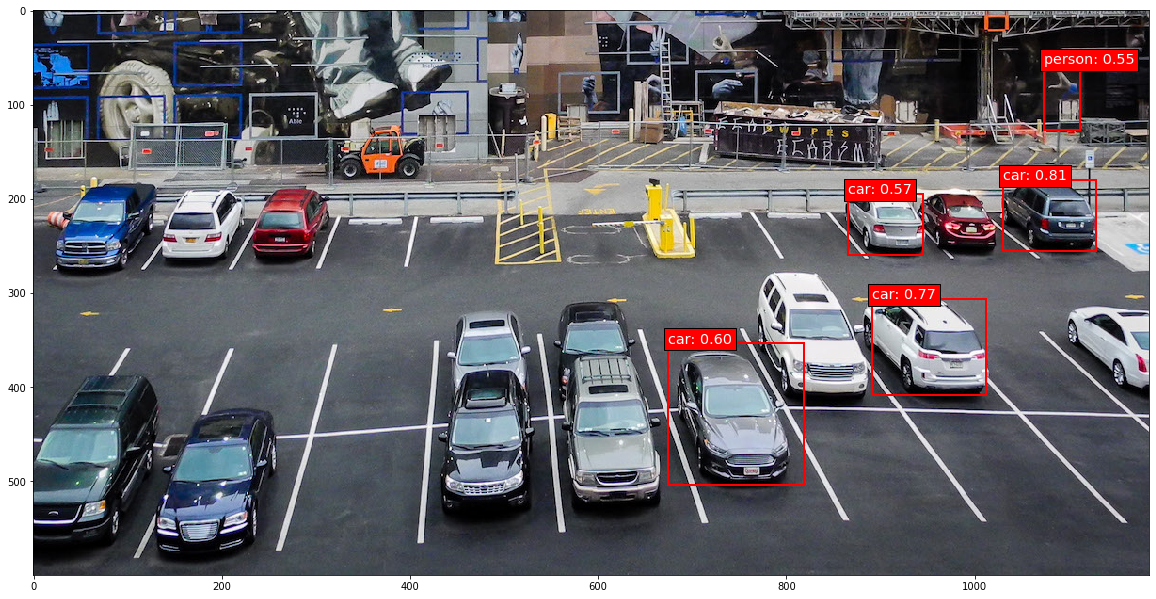

In [18]:
# Display the image and draw the predicted boxes onto it.

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
classes = ['background', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 
           'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 
           'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 
           'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 
           'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 
           'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 
           'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 
           'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 
           'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

plt.figure(figsize=(20,12))
plt.imshow(orig_images[0])

current_axis = plt.gca()

for box in y_pred_thresh[0]:
    # Transform the predicted bounding boxes for the 300x300 image to the original image dimensions.
    xmin = box[2] * orig_images[0].shape[1] / img_width
    ymin = box[3] * orig_images[0].shape[0] / img_height
    xmax = box[4] * orig_images[0].shape[1] / img_width
    
    ymax = box[5] * orig_images[0].shape[0] / img_height
    color = (1, 0, 0)
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

## webcam

In [49]:
def draw_predict(frame, left, top, right, bottom, label, conf=-1):
    # Draw a bounding box.
    cv2.rectangle(frame, (left, top), (right, bottom), COLOR_YELLOW, 2)

    text = '{}: {:.2f}'.format(label, conf)

    # Display the label at the top of the bounding box
    label_size, base_line = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)

    top = max(top, label_size[1])
    cv2.putText(frame, text, (left, top - 4), cv2.FONT_HERSHEY_SIMPLEX, 0.4,
                COLOR_WHITE, 1)
    

# Default colors
COLOR_BLUE = (255, 0, 0)
COLOR_GREEN = (0, 255, 0)
COLOR_RED = (0, 0, 255)
COLOR_WHITE = (255, 255, 255)
COLOR_YELLOW = (0, 255, 255)

cap = cv2.VideoCapture(0)
time.sleep(2.0)

fps = FPS().start()

while True:
    ret, frame = cap.read()
    if ret!=True:
        print('Not able to load image from webcam')
        break
    
    cv2.imwrite('frame.jpg', frame)
    img = image.load_img('frame.jpg', target_size=(img_height, img_width))
    img = image.img_to_array(img) 
    
    y_pred = model.predict(np.array([img]))
    
    confidence_threshold = 0.5
    y_pred_thresh = [y_pred[k][y_pred[k,:,1] > confidence_threshold] for k in range(y_pred.shape[0])]

    np.set_printoptions(precision=2, suppress=True, linewidth=90)
    print("Predicted boxes:\n")
    print('   class   conf xmin   ymin   xmax   ymax')
    print(y_pred_thresh[0])
    
    for box in y_pred_thresh[0]:
        # Transform the predicted bounding boxes for the 300x300 image to the original image dimensions.
        xmin = int(box[2] * frame.shape[1] / img_width)
        ymin = int(box[3] * frame.shape[0] / img_height)
        xmax = int(box[4] * frame.shape[1] / img_width)
        ymax = int(box[5] * frame.shape[0] / img_height)
        
        label, conf = classes[int(box[0])], box[1]
        
        draw_predict(frame, xmin, ymin, xmax, ymax, label, conf)

    cv2.imshow('object detection SSD', frame)

    key = cv2.waitKey(1)
    if key == 27 or key == ord('q'):
        break

    # update the FPS counter
    fps.update()

# stop the timer and display FPS information
fps.stop()
print("[INFO] elapsed time: {:.2f}".format(fps.elapsed()))
print("[INFO] approx. FPS: {:.2f}".format(fps.fps()))

cap.release()
cv2.destroyAllWindows()

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  1.     0.97  84.75 111.16 255.05 264.98]]
Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  1.     0.95  94.   112.24 259.78 264.68]]
Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  1.     0.96 100.37 116.3  257.03 264.31]]
Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  1.     0.98 107.5  120.8  249.   267.27]]
Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  1.     0.98 106.99 124.01 254.88 263.29]]
Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  1.     0.96 102.23 123.14 249.81 264.55]]
Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  1.     0.86  97.7  125.96 223.65 267.46]]
Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  1.     0.93  74.48 123.86 188.7  259.66]]
Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  1.     0.99  78.79 129.54 214.37 264.3 ]]
Predicted boxes:

   class   conf xmin   ymin 

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  1.     0.97  89.6  133.47 235.96 264.73]]
Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  1.     0.97  91.7  141.96 238.47 263.75]]
Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  1.     0.96  92.48 143.31 235.24 264.61]]
Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  1.     0.96  89.35 142.16 236.81 264.75]]
Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  1.     0.96  88.09 142.49 235.19 265.15]]
Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  1.     0.96  90.06 143.05 235.13 264.45]]
Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  1.     0.98  94.01 143.86 235.17 264.29]]
Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  1.     0.96  91.8  144.7  234.19 264.44]]
Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  1.     0.97  90.88 141.36 234.38 264.05]]
Predicted boxes:

   class   conf xmin   ymin 

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[ 57.     0.79 106.39 165.7  168.51 256.  ]
 [  1.     0.77 109.72 125.57 167.99 248.92]]
Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[ 57.     0.91 108.6  163.71 170.54 257.3 ]
 [ 57.     0.8    0.76 176.81  53.01 250.69]
 [ 59.     0.69 154.38  63.72 185.81 120.73]
 [  1.     0.55 112.38 133.67 169.03 245.38]]
Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[ 57.     0.9  108.24 165.26 170.78 257.59]
 [ 59.     0.64 153.61  65.14 185.13 122.04]
 [ 57.     0.6    0.97 177.73  50.99 249.89]]
Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[ 57.     0.95 109.05 165.07 171.82 256.85]
 [ 57.     0.78   0.48 176.63  50.94 249.84]
 [ 59.     0.64 154.42  63.6  184.87 122.88]
 [  1.     0.63 114.58 133.62 167.7  244.96]]
Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[ 57.     0.94 109.09 165.66 170.8  257.33]
 [ 57.     0.69   0.52 177.95  52.2  251.34]
 [ 59.     0.62 153.7

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[]
Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[]
Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[]
Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  1.     0.6  167.91 215.31 228.51 262.27]]
Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  1.     0.69 136.23 112.41 283.6  258.01]]
Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  1.     0.88   9.74  32.83 301.74 263.74]]
Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  1.     0.89 110.44 133.3  203.72 259.49]]
[INFO] elapsed time: 102.35
[INFO] approx. FPS: 2.03
